In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("clean_data.csv", low_memory = False, index_col = "Unnamed: 0")

In [3]:
# sorting out ER_VISIT, ER_ED_VISIT, OFC_VISIT form field differences
# rows with ER_VISIT = Y and all the other categories are blank, add to OFC_VISIT
er_only = pd.DataFrame(df.loc[df["ER_VISIT"] == "Y"].loc[df["DIED"] != "Y"].loc[df["HOSPITAL"] != "Y"].loc[df["L_THREAT"] != "Y"].loc[df["DISABLE"] != "Y"].loc[df["X_STAY"] != "Y"])
er_only["OFC_VISIT"] = "Y"
len(er_only)

33987

In [4]:
# update corresponding rows in the main dataframe
df.update(er_only)

In [5]:
# Creating a category for people with no doctors involved
c = ["OFC_VISIT", "ER_ED_VISIT", "HOSPITAL", "X_STAY", "DISABLE", "L_THREAT", "DIED"]

# Find rows that have no Y values in any of the columns above
# store in new NO_DOCTOR column
no_doctor_df = df.loc[df[c[0]] != "Y"].loc[df[c[1]] != "Y"].loc[df[c[2]] != "Y"].loc[df[c[3]] != "Y"].loc[df[c[4]] != "Y"].loc[df[c[5]] != "Y"].loc[df[c[6]] != "Y"]
no_doctor_df["NO_DOCTOR"] = "Y"

# combine with original dataframe
df = pd.merge(df, no_doctor_df[["VAERS_ID", "NO_DOCTOR"]], on = "VAERS_ID", how = "left")

In [6]:
df[["NO_DOCTOR", "OFC_VISIT", "ER_ED_VISIT", "HOSPITAL", "X_STAY", "DISABLE", "L_THREAT", "DIED"]].count()

NO_DOCTOR      395759
OFC_VISIT      139930
ER_ED_VISIT     63751
HOSPITAL        29950
X_STAY            826
DISABLE          9041
L_THREAT         9042
DIED             5487
dtype: int64

In [7]:
# Get covid vaccine data
covid_df = df.loc[df["VAX_TYPE"] == "COVID19"]

# split by gender
f_covid_df = covid_df.loc[covid_df["SEX"] == "F"]
m_covid_df = covid_df.loc[covid_df["SEX"] == "M"]

# categories of reaction severity
cols = ["SEX", "NO_DOCTOR", "OFC_VISIT", "ER_ED_VISIT", "HOSPITAL", "DISABLE", "L_THREAT", "DIED"]

In [8]:
covid_df[cols].count()

SEX            385931
NO_DOCTOR      255159
OFC_VISIT       78700
ER_ED_VISIT     54387
HOSPITAL        21872
DISABLE          5338
L_THREAT         6559
DIED             4856
dtype: int64

In [9]:
# age information
pd.DataFrame(round(covid_df["AGE_YRS"].describe(), 1)).transpose()

,count,mean,std,min,25%,50%,75%,max
AGE_YRS,385931.0,48.8,18.1,12.0,35.0,49.0,63.0,119.0


In [10]:
# make 8 year bins and names of each
stepsize = 8
bins = list([np.arange(11, 128, stepsize)])[0]
group_names = []

for age in bins[0: -1]:
    group_names.append(str(f"{age} to {age + stepsize - 1}"))
    
group_names[0] = f"Under {bins[1]}"
group_names[-1] = f"Over {bins[-2] - 1}"
group_names

['Under 19',
 '19 to 26',
 '27 to 34',
 '35 to 42',
 '43 to 50',
 '51 to 58',
 '59 to 66',
 '67 to 74',
 '75 to 82',
 '83 to 90',
 '91 to 98',
 '99 to 106',
 '107 to 114',
 'Over 114']

In [11]:
# all covid data, grouped by age range
covid_agebins_df = covid_df.copy()[cols]
covid_agebins_df["Bins"] = pd.cut(covid_df["AGE_YRS"], bins, labels = group_names, include_lowest = True)

covid_age_df = pd.DataFrame(covid_agebins_df.groupby("Bins").count())
covid_age_df

,SEX,NO_DOCTOR,OFC_VISIT,ER_ED_VISIT,HOSPITAL,DISABLE,L_THREAT,DIED
Bins,,,,,,,,
Under 19,18672,13794,2409,2507,1001,61,213,23
19 to 26,33381,23379,5679,4919,1021,189,309,42
27 to 34,50886,34640,10536,7090,1357,408,479,67
35 to 42,56522,37365,12680,8224,1723,653,717,116
43 to 50,54498,35776,12285,7806,1996,729,843,210
51 to 58,53681,35899,11369,7118,2558,803,916,329
59 to 66,51856,34835,10387,6478,3387,957,1103,696
67 to 74,38579,24988,7826,5012,3690,797,973,938
75 to 82,18381,10287,3767,3174,2984,452,589,1001


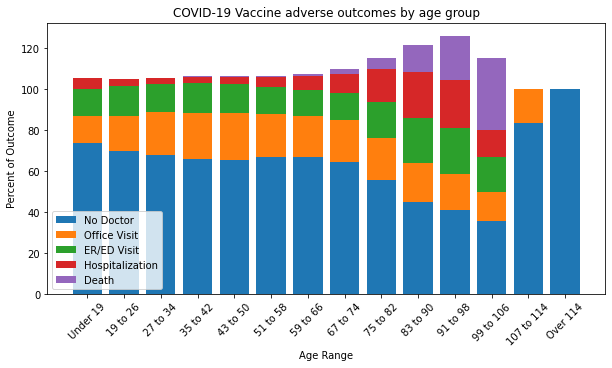

In [12]:
s = covid_age_df[cols[0]]
x = covid_age_df.index
y1 = 100 * covid_age_df[cols[1]] / s
y2 = 100 * covid_age_df[cols[2]] / s
y3 = 100 * covid_age_df[cols[3]] / s
y4 = 100 * covid_age_df[cols[4]] / s
y7 = 100 * covid_age_df[cols[7]] / s

plt.figure(figsize = (10,5))
plt.bar(x, y1)
plt.bar(x, y2, bottom = y1)
plt.bar(x, y3, bottom = y1 + y2)
plt.bar(x, y4, bottom = y1 + y2 + y3)
plt.bar(x, y7, bottom = y1 + y2 + y3 + y4)

plt.xlabel("Age Range")
plt.xticks(rotation = 45)
plt.ylabel("Percent of Outcome")
plt.legend(["No Doctor", "Office Visit", "ER/ED Visit", "Hospitalization", "Death"])
plt.title("COVID-19 Vaccine adverse outcomes by age group")

plt.savefig("Images/agebar.png")
plt.show()

In [13]:
# covid data for females, grouped by age range
f_covid_agebins_df = f_covid_df[cols].copy()
f_covid_agebins_df["Bins"] = pd.cut(f_covid_df["AGE_YRS"], bins, labels = group_names, include_lowest = True)

f_covid_age_df = pd.DataFrame(f_covid_agebins_df.groupby("Bins").count())
f_covid_age_df

,SEX,NO_DOCTOR,OFC_VISIT,ER_ED_VISIT,HOSPITAL,DISABLE,L_THREAT,DIED
Bins,,,,,,,,
Under 19,10470,7827,1360,1432,310,31,83,11
19 to 26,23201,16313,4045,3349,494,127,175,13
27 to 34,37613,25371,8178,5204,811,269,305,22
35 to 42,43190,28577,9819,6183,1085,387,445,46
43 to 50,41684,27450,9473,5953,1187,430,526,90
51 to 58,39941,27046,8454,5163,1423,437,504,134
59 to 66,37046,25624,7315,4307,1723,525,546,272
67 to 74,26423,17980,5189,2992,1872,435,457,370
75 to 82,11711,7009,2380,1773,1516,245,297,426


In [14]:
# covid data for males, grouped by age range
m_covid_agebins_df = m_covid_df[cols].copy()
m_covid_agebins_df["Bins"] = pd.cut(m_covid_df["AGE_YRS"], bins, labels = group_names, include_lowest = True)

m_covid_age_df = pd.DataFrame(m_covid_agebins_df.groupby("Bins").count())
m_covid_age_df

,SEX,NO_DOCTOR,OFC_VISIT,ER_ED_VISIT,HOSPITAL,DISABLE,L_THREAT,DIED
Bins,,,,,,,,
Under 19,7950,5734,1035,1069,688,30,130,12
19 to 26,9949,6871,1610,1555,526,62,134,29
27 to 34,12992,9055,2326,1851,540,139,172,45
35 to 42,13061,8575,2828,2015,635,265,270,70
43 to 50,12545,8129,2776,1818,803,294,311,116
51 to 58,13491,8646,2897,1932,1128,364,410,195
59 to 66,14533,9001,3038,2144,1653,427,551,420
67 to 74,11972,6865,2628,2000,1805,360,516,561
75 to 82,6561,3207,1369,1389,1455,205,290,572


#### Gender Distribution

In [15]:
pd.DataFrame(covid_df["SEX"].value_counts())

,SEX
F,277299
M,106451
U,2181


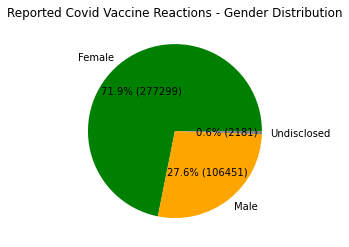

In [16]:
# pie chart of gender distribution of reports

# get autopct to dispaly percentage and value
# https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}% ({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.figure(figsize = (6, 4))
plt.pie(covid_df["SEX"].value_counts(), 
        labels = covid_df["SEX"].value_counts().index.map({"F": "Female", "M": "Male", "U": "Undisclosed"}),
        colors = ["green", "orange", "gray"],
        autopct = make_autopct(covid_df["SEX"].value_counts())
       )

#plt.table([["F", "M", "U"], [covid_df["SEX"].value_counts()[0], covid_df["SEX"].value_counts()[1], covid_df["SEX"].value_counts()[2]]])
plt.title("Reported Covid Vaccine Reactions - Gender Distribution")

plt.savefig("Images/genderpie.png")
plt.show()

#### Reaction severity categories sorted by gender and age range

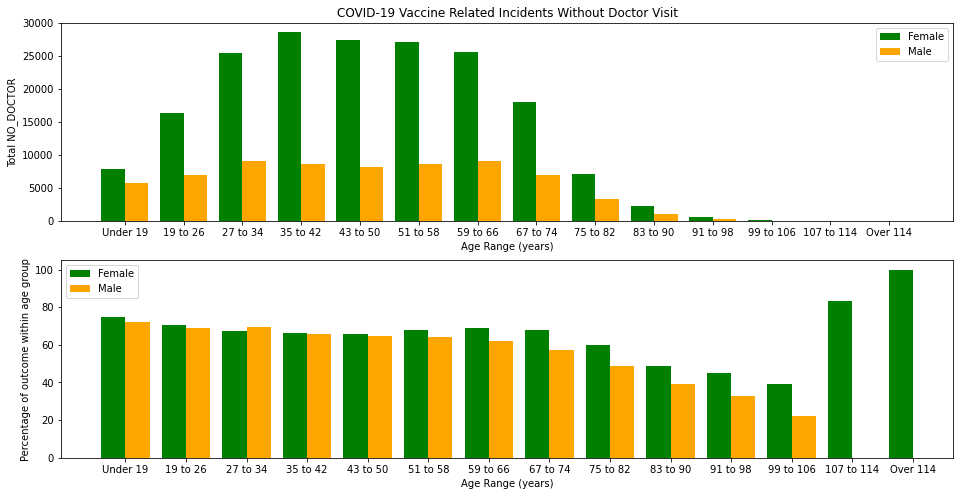

In [17]:
# 0: SEX
# 1: NO_DOCTOR
# 2: OFC_VISIT
# 3: ER_ED_VISIT
# 4: HOSPITAL
# 5: DISABLE
# 6: L_THREAT
# 7: DIED

z = 1
x = group_names
y1 = f_covid_age_df[cols[z]]
y2 = m_covid_age_df[cols[z]]

plt.figure(figsize = (16, 8))

plt.subplot(2, 1, 1)
plt.bar(x, y1, width = -0.4, align = "edge", color = "green")
plt.bar(x, y2, width = 0.4, align = "edge", color = "orange")
plt.title("COVID-19 Vaccine Related Incidents Without Doctor Visit")
plt.xlabel("Age Range (years)")
plt.ylabel(f"Total {cols[z]}")
plt.legend(["Female", "Male"])

plt.subplot(2, 1, 2)
plt.bar(x, y1 * 100 / f_covid_age_df["SEX"], width = -0.4, align = "edge", color = "green")
plt.bar(x, y2 * 100 / m_covid_age_df["SEX"], width = 0.4, align = "edge", color = "orange")
plt.xlabel("Age Range (years)")
plt.ylabel("Percentage of outcome within age group")
plt.legend(["Female", "Male"])

plt.show()

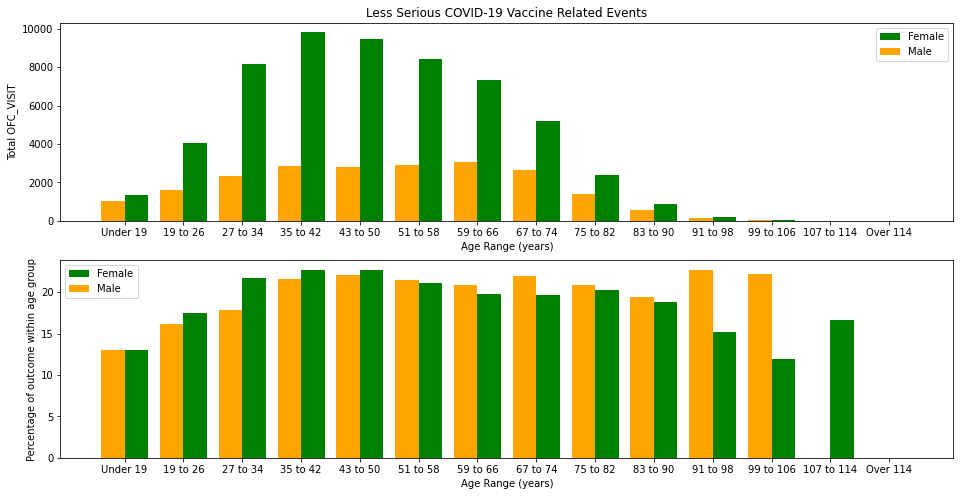

In [18]:
# 0: SEX
# 1: NO_DOCTOR
# 2: OFC_VISIT
# 3: ER_ED_VISIT
# 4: HOSPITAL
# 5: DISABLE
# 6: L_THREAT
# 7: DIED

z = 2
x = group_names
y1 = f_covid_age_df[cols[z]]
y2 = m_covid_age_df[cols[z]]

plt.figure(figsize = (16, 8))

plt.subplot(2, 1, 1)
plt.bar(x, y1, width = 0.4, align = "edge", color = "green")
plt.bar(x, y2, width = -0.4, align = "edge", color = "orange")
plt.title("Less Serious COVID-19 Vaccine Related Events")
plt.xlabel("Age Range (years)")
plt.ylabel(f"Total {cols[z]}")
plt.legend(["Female", "Male"])

plt.subplot(2, 1, 2)
plt.bar(x, y1 * 100 / f_covid_age_df["SEX"], width = 0.4, align = "edge", color = "green")
plt.bar(x, y2 * 100 / m_covid_age_df["SEX"], width = -0.4, align = "edge", color = "orange")
plt.xlabel("Age Range (years)")
plt.ylabel("Percentage of outcome within age group")
plt.legend(["Female", "Male"])

plt.show()

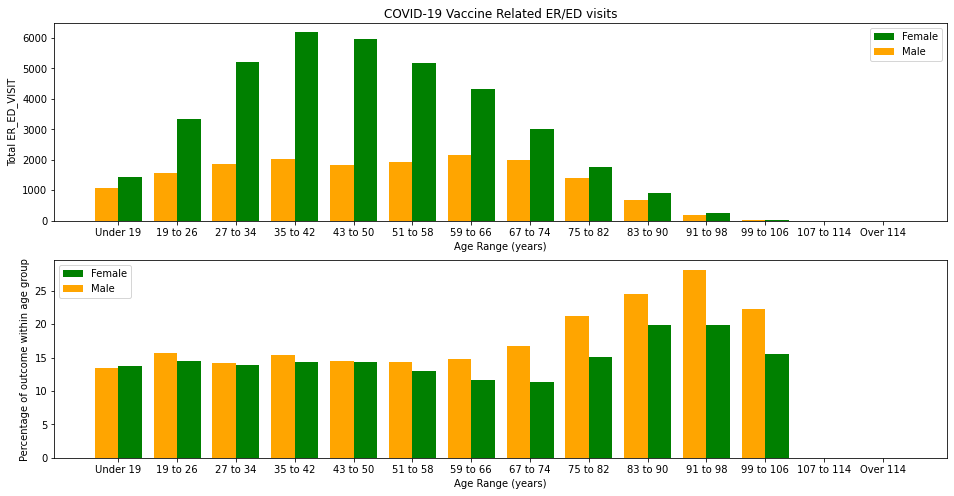

In [19]:
# 0: SEX
# 1: NO_DOCTOR
# 2: OFC_VISIT
# 3: ER_ED_VISIT
# 4: HOSPITAL
# 5: DISABLE
# 6: L_THREAT
# 7: DIED

z = 3
x = group_names
y1 = f_covid_age_df[cols[z]]
y2 = m_covid_age_df[cols[z]]

plt.figure(figsize = (16, 8))

plt.subplot(2, 1, 1)
plt.bar(x, y1, width = 0.4, align = "edge", color = "green")
plt.bar(x, y2, width = -0.4, align = "edge", color = "orange")
plt.title("COVID-19 Vaccine Related ER/ED visits")
plt.xlabel("Age Range (years)")
plt.ylabel(f"Total {cols[z]}")
plt.legend(["Female", "Male"])

plt.subplot(2, 1, 2)
plt.bar(x, y1 * 100 / f_covid_age_df["SEX"], width = 0.4, align = "edge", color = "green")
plt.bar(x, y2 * 100 / m_covid_age_df["SEX"], width = -0.4, align = "edge", color = "orange")
plt.xlabel("Age Range (years)")
plt.ylabel("Percentage of outcome within age group")
plt.legend(["Female", "Male"])

plt.show()

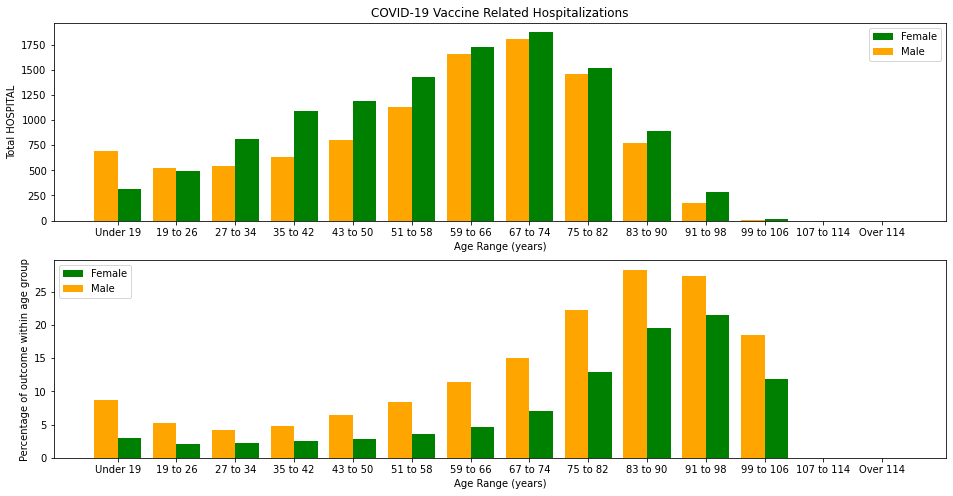

In [20]:
# 0: SEX
# 1: NO_DOCTOR
# 2: OFC_VISIT
# 3: ER_ED_VISIT
# 4: HOSPITAL
# 5: DISABLE
# 6: L_THREAT
# 7: DIED

z = 4
x = group_names
y1 = f_covid_age_df[cols[z]]
y2 = m_covid_age_df[cols[z]]

plt.figure(figsize = (16, 8))

plt.subplot(2, 1, 1)
plt.bar(x, y1, width = 0.4, align = "edge", color = "green")
plt.bar(x, y2, width = -0.4, align = "edge", color = "orange")
plt.title("COVID-19 Vaccine Related Hospitalizations")
plt.xlabel("Age Range (years)")
plt.ylabel(f"Total {cols[z]}")
plt.legend(["Female", "Male"])

plt.subplot(2, 1, 2)
plt.bar(x, y1 * 100 / f_covid_age_df["SEX"], width = 0.4, align = "edge", color = "green")
plt.bar(x, y2 * 100 / m_covid_age_df["SEX"], width = -0.4, align = "edge", color = "orange")
plt.xlabel("Age Range (years)")
plt.ylabel("Percentage of outcome within age group")
plt.legend(["Female", "Male"])

plt.show()

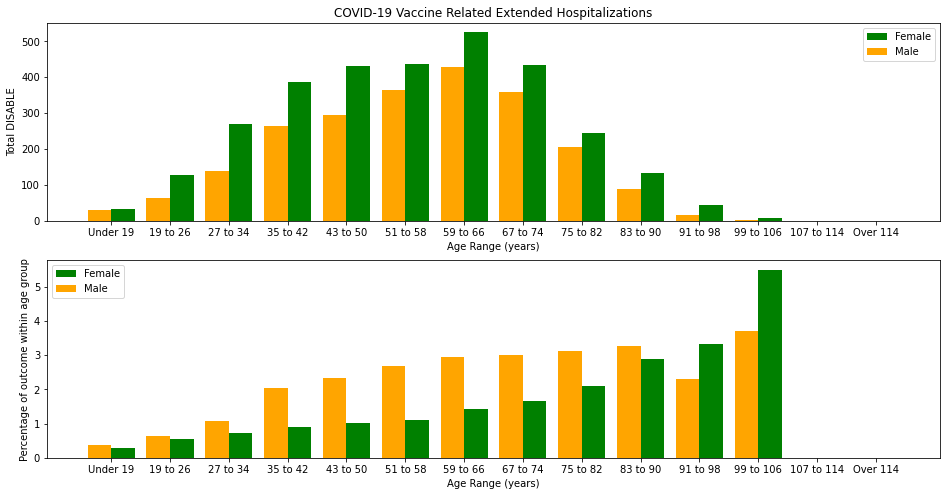

In [21]:
# 0: SEX
# 1: NO_DOCTOR
# 2: OFC_VISIT
# 3: ER_ED_VISIT
# 4: HOSPITAL
# 5: DISABLE
# 6: L_THREAT
# 7: DIED

z = 5
x = group_names
y1 = f_covid_age_df[cols[z]]
y2 = m_covid_age_df[cols[z]]

plt.figure(figsize = (16, 8))

plt.subplot(2, 1, 1)
plt.bar(x, y1, width = 0.4, align = "edge", color = "green")
plt.bar(x, y2, width = -0.4, align = "edge", color = "orange")
plt.title("COVID-19 Vaccine Related Extended Hospitalizations")
plt.xlabel("Age Range (years)")
plt.ylabel(f"Total {cols[z]}")
plt.legend(["Female", "Male"])

plt.subplot(2, 1, 2)
plt.bar(x, y1 * 100 / f_covid_age_df["SEX"], width = 0.4, align = "edge", color = "green")
plt.bar(x, y2 * 100 / m_covid_age_df["SEX"], width = -0.4, align = "edge", color = "orange")
plt.xlabel("Age Range (years)")
plt.ylabel("Percentage of outcome within age group")
plt.legend(["Female", "Male"])

plt.show()

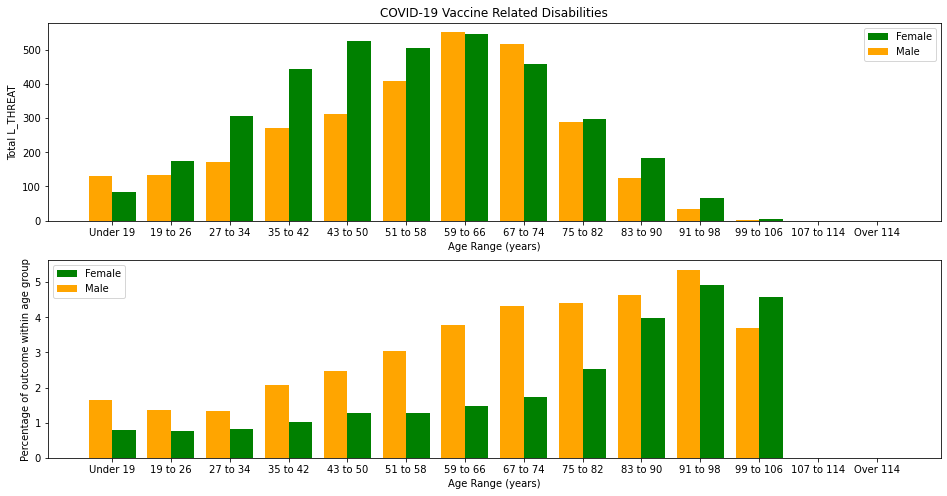

In [22]:
# 0: SEX
# 1: NO_DOCTOR
# 2: OFC_VISIT
# 3: ER_ED_VISIT
# 4: HOSPITAL
# 5: DISABLE
# 6: L_THREAT
# 7: DIED

z = 6
x = group_names
y1 = f_covid_age_df[cols[z]]
y2 = m_covid_age_df[cols[z]]

plt.figure(figsize = (16, 8))

plt.subplot(2, 1, 1)
plt.bar(x, y1, width = 0.4, align = "edge", color = "green")
plt.bar(x, y2, width = -0.4, align = "edge", color = "orange")
plt.title("COVID-19 Vaccine Related Disabilities")
plt.xlabel("Age Range (years)")
plt.ylabel(f"Total {cols[z]}")
plt.legend(["Female", "Male"])

plt.subplot(2, 1, 2)
plt.bar(x, y1 * 100 / f_covid_age_df["SEX"], width = 0.4, align = "edge", color = "green")
plt.bar(x, y2 * 100 / m_covid_age_df["SEX"], width = -0.4, align = "edge", color = "orange")
plt.xlabel("Age Range (years)")
plt.ylabel("Percentage of outcome within age group")
plt.legend(["Female", "Male"])

plt.show()

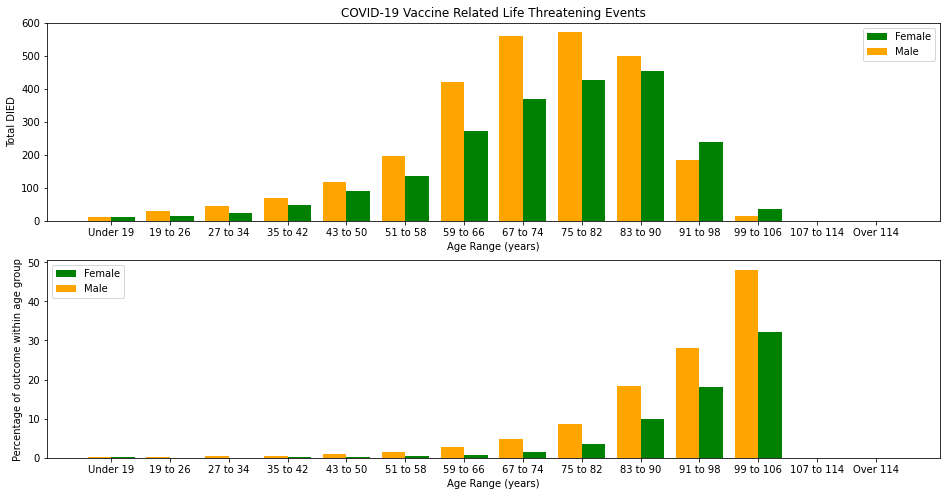

In [23]:
# 0: SEX
# 1: NO_DOCTOR
# 2: OFC_VISIT
# 3: ER_ED_VISIT
# 4: HOSPITAL
# 5: DISABLE
# 6: L_THREAT
# 7: DIED

z = 7
x = group_names
y1 = f_covid_age_df[cols[z]]
y2 = m_covid_age_df[cols[z]]

plt.figure(figsize = (16, 8))

plt.subplot(2, 1, 1)
plt.bar(x, y1, width = 0.4, align = "edge", color = "green")
plt.bar(x, y2, width = -0.4, align = "edge", color = "orange")
plt.title("COVID-19 Vaccine Related Life Threatening Events")
plt.xlabel("Age Range (years)")
plt.ylabel(f"Total {cols[z]}")
plt.legend(["Female", "Male"])

plt.subplot(2, 1, 2)
plt.bar(x, y1 * 100 / f_covid_age_df["SEX"], width = 0.4, align = "edge", color = "green")
plt.bar(x, y2 * 100 / m_covid_age_df["SEX"], width = -0.4, align = "edge", color = "orange")
plt.xlabel("Age Range (years)")
plt.ylabel("Percentage of outcome within age group")
plt.legend(["Female", "Male"])

plt.show()

In [25]:
# count the types of outcome for F and M
outcomes_df = pd.DataFrame({
    "No Doctor": [len(f_covid_df.loc[f_covid_df["NO_DOCTOR"] == "Y"]), len(m_covid_df.loc[m_covid_df["NO_DOCTOR"] == "Y"])],
    "Office Visit": [len(f_covid_df.loc[f_covid_df["OFC_VISIT"] == "Y"]), len(m_covid_df.loc[m_covid_df["OFC_VISIT"] == "Y"])],
    "ER/ED Visit": [len(f_covid_df.loc[f_covid_df["ER_ED_VISIT"] == "Y"]), len(m_covid_df.loc[m_covid_df["ER_ED_VISIT"] == "Y"])],
    "Hospitalization": [len(f_covid_df.loc[f_covid_df["HOSPITAL"] == "Y"]), len(m_covid_df.loc[m_covid_df["HOSPITAL"] == "Y"])],
#     "X_STAY": [len(f_covid_df.loc[f_covid_df["X_STAY"] == "Y"]), len(m_covid_df.loc[m_covid_df["X_STAY"] == "Y"])],
    "Life Threat": [len(f_covid_df.loc[f_covid_df["L_THREAT"] == "Y"]), len(m_covid_df.loc[m_covid_df["L_THREAT"] == "Y"])],   
    "Disabled": [len(f_covid_df.loc[f_covid_df["DISABLE"] == "Y"]), len(m_covid_df.loc[m_covid_df["DISABLE"] == "Y"])],
    "Died": [len(f_covid_df.loc[f_covid_df["DIED"] == "Y"]), len(m_covid_df.loc[m_covid_df["DIED"] == "Y"])]
    
}).rename(index = {0: "F", 1: "M"}).transpose()

outcomes_df

,F,M
No Doctor,186074,67364
Office Visit,57292,21188
ER/ED Visit,37547,16631
Hospitalization,11611,10187
Life Threat,3591,2946
Disabled,3069,2251
Died,2114,2718


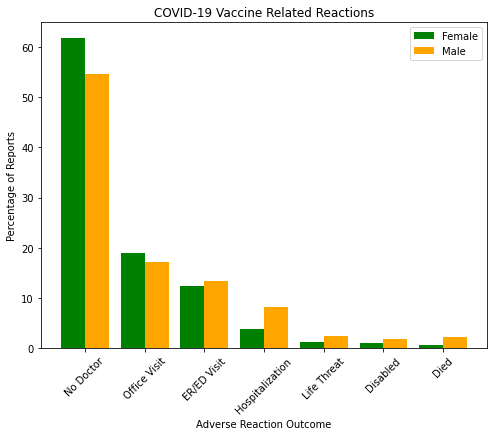

In [26]:
x = outcomes_df.index
y1 = 100 * outcomes_df["F"] / sum(outcomes_df["F"])
y2 = 100 * outcomes_df["M"] / sum(outcomes_df["M"])

plt.figure(figsize = (8, 6))

plt.bar(x, y1, width = -0.4, align = "edge", color = "green")
plt.bar(x, y2, width = 0.4, align = "edge", color = "orange")
plt.title("COVID-19 Vaccine Related Reactions")
plt.xlabel("Adverse Reaction Outcome")
plt.xticks(rotation = 45)
plt.ylabel("Percentage of Reports")
plt.legend(["Female", "Male"])

plt.savefig("Images/genderbar.png", transparent = True)
plt.show()

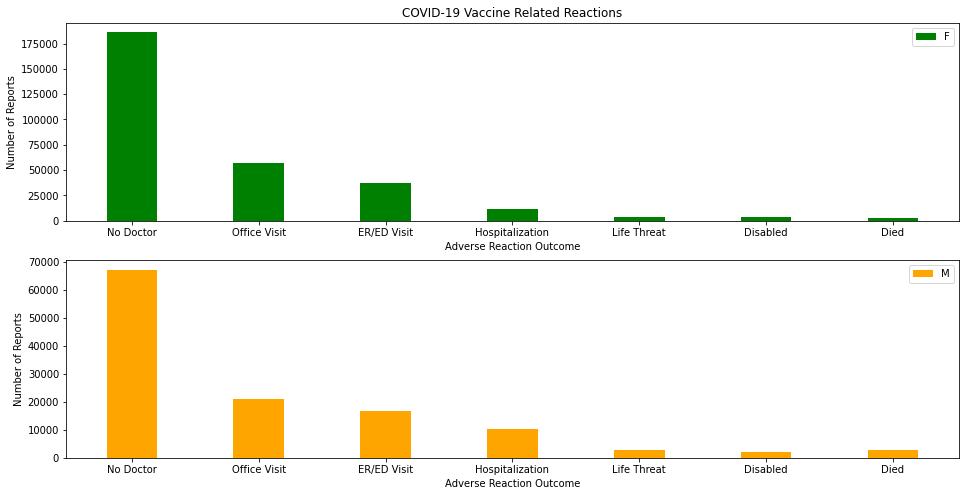

In [27]:
x = outcomes_df.index
y1 = outcomes_df["F"]
y2 = outcomes_df["M"]

plt.figure(figsize = (16, 8))

plt.subplot(2, 1, 1)
plt.bar(x, y1, width = 0.4, align = "center", color = "green")
plt.title("COVID-19 Vaccine Related Reactions")
plt.xlabel("Adverse Reaction Outcome")
plt.ylabel("Number of Reports")
plt.legend("Female")

plt.subplot(2, 1, 2)
plt.bar(x, y2, width = 0.4, align = "center", color = "orange")
plt.xlabel("Adverse Reaction Outcome")
plt.ylabel("Number of Reports")
plt.legend("Male")

plt.show()

#### Info for other vaccines

In [28]:
notcovid_df = df.loc[df["VAX_TYPE"] != "COVID19"]
f_notcovid_df = notcovid_df.loc[notcovid_df["SEX"] == "F"]
m_notcovid_df = notcovid_df.loc[notcovid_df["SEX"] == "M"]
cols = ["SEX", "NO_DOCTOR", "OFC_VISIT", "ER_ED_VISIT", "HOSPITAL", "DISABLE", "L_THREAT", "DIED"]

In [29]:
# all covid data, grouped by age range
notcovid_agebins_df = notcovid_df.copy()[cols]
notcovid_agebins_df["Bins"] = pd.cut(notcovid_df["AGE_YRS"], bins, labels = group_names, include_lowest = True)

notcovid_age_df = pd.DataFrame(notcovid_agebins_df.groupby("Bins").count())
notcovid_age_df

,SEX,NO_DOCTOR,OFC_VISIT,ER_ED_VISIT,HOSPITAL,DISABLE,L_THREAT,DIED
Bins,,,,,,,,
Under 19,30116,19952,7811,1369,1277,559,390,87
19 to 26,16079,10064,4734,736,683,280,184,17
27 to 34,14884,8874,4847,697,622,273,221,11
35 to 42,13630,8009,4603,618,544,267,204,25
43 to 50,16814,10402,5187,673,629,369,239,34
51 to 58,27238,18138,7422,1102,855,517,301,52
59 to 66,45146,30685,11948,1625,1232,710,397,94
67 to 74,33206,21949,9037,1528,1123,439,294,95
75 to 82,14507,9194,4124,727,716,211,167,96


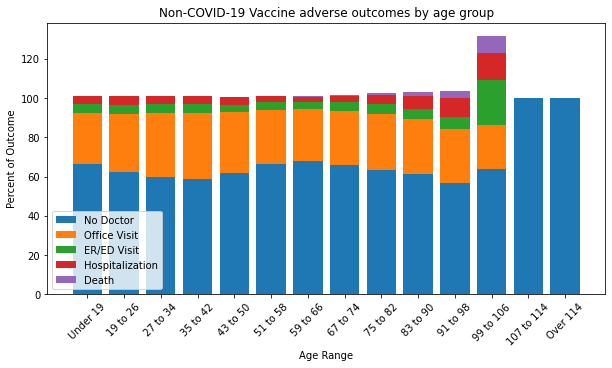

In [36]:
s = notcovid_age_df[cols[0]]
x = notcovid_age_df.index
y1 = 100 * notcovid_age_df[cols[1]] / s
y2 = 100 * notcovid_age_df[cols[2]] / s
y3 = 100 * notcovid_age_df[cols[3]] / s
y4 = 100 * notcovid_age_df[cols[4]] / s
y7 = 100 * notcovid_age_df[cols[7]] / s

plt.figure(figsize = (10,5))
plt.bar(x, y1)
plt.bar(x, y2, bottom = y1)
plt.bar(x, y3, bottom = y1 + y2)
plt.bar(x, y4, bottom = y1 + y2 + y3)
plt.bar(x, y7, bottom = y1 + y2 + y3 + y4)

plt.xlabel("Age Range")
plt.xticks(rotation = 45)
plt.ylabel("Percent of Outcome")
plt.legend(["No Doctor", "Office Visit", "ER/ED Visit", "Hospitalization", "Death"])
plt.title("Non-COVID-19 Vaccine adverse outcomes by age group")

plt.savefig("Images/notcovid_agebar.png")
plt.show()

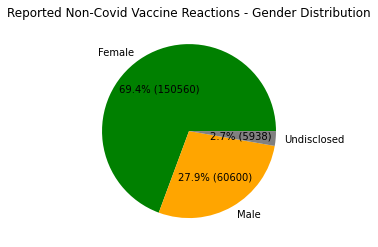

In [37]:
# pie chart of gender distribution of reports

# get autopct to dispaly percentage and value
# https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}% ({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.figure(figsize = (6, 4))
plt.pie(notcovid_df["SEX"].value_counts(), 
        labels = notcovid_df["SEX"].value_counts().index.map({"F": "Female", "M": "Male", "U": "Undisclosed"}),
        colors = ["green", "orange", "gray"],
        autopct = make_autopct(notcovid_df["SEX"].value_counts())
       )

#plt.table([["F", "M", "U"], [covid_df["SEX"].value_counts()[0], covid_df["SEX"].value_counts()[1], covid_df["SEX"].value_counts()[2]]])
plt.title("Reported Non-Covid Vaccine Reactions - Gender Distribution")

plt.savefig("Images/notcovid_genderpie.png")
plt.show()

In [32]:
# not covid data for females, grouped by age range
f_notcovid_agebins_df = f_notcovid_df[cols].copy()
f_notcovid_agebins_df["Bins"] = pd.cut(f_notcovid_df["AGE_YRS"], bins, labels = group_names, include_lowest = True)

f_notcovid_age_df = pd.DataFrame(f_notcovid_agebins_df.groupby("Bins").count())
f_notcovid_age_df

,SEX,NO_DOCTOR,OFC_VISIT,ER_ED_VISIT,HOSPITAL,DISABLE,L_THREAT,DIED
Bins,,,,,,,,
Under 19,16736,10501,4820,816,765,408,250,50
19 to 26,11403,7200,3414,479,368,207,112,8
27 to 34,10728,6391,3557,516,393,175,151,4
35 to 42,10035,5854,3506,470,326,187,139,9
43 to 50,12377,7522,4035,512,388,255,145,13
51 to 58,20069,13291,5708,782,482,304,169,22
59 to 66,32211,21846,8826,1126,649,418,208,30
67 to 74,23241,15346,6546,1067,596,271,141,34
75 to 82,9902,6324,2872,489,386,115,78,38


In [33]:
# covid data for males, grouped by age range
m_notcovid_agebins_df = m_notcovid_df[cols].copy()
m_notcovid_agebins_df["Bins"] = pd.cut(m_notcovid_df["AGE_YRS"], bins, labels = group_names, include_lowest = True)

m_notcovid_age_df = pd.DataFrame(m_notcovid_agebins_df.groupby("Bins").count())
m_notcovid_age_df

,SEX,NO_DOCTOR,OFC_VISIT,ER_ED_VISIT,HOSPITAL,DISABLE,L_THREAT,DIED
Bins,,,,,,,,
Under 19,11149,7291,2936,543,507,150,140,34
19 to 26,4238,2459,1290,254,314,72,71,9
27 to 34,3871,2227,1262,181,229,97,70,7
35 to 42,3337,1938,1059,147,217,79,65,16
43 to 50,4124,2609,1115,158,240,112,94,21
51 to 58,6751,4489,1658,314,372,212,131,30
59 to 66,11991,8005,3019,496,578,286,188,64
67 to 74,9304,6034,2410,455,523,163,153,61
75 to 82,4329,2650,1200,236,328,95,89,57


In [34]:
notcovid_outcomes_df = pd.DataFrame({
    "No Doctor": [len(f_notcovid_df.loc[f_notcovid_df["NO_DOCTOR"] == "Y"]), len(m_notcovid_df.loc[m_notcovid_df["NO_DOCTOR"] == "Y"])],
    "Office Visit": [len(f_notcovid_df.loc[f_notcovid_df["OFC_VISIT"] == "Y"]), len(m_notcovid_df.loc[m_notcovid_df["OFC_VISIT"] == "Y"])],
    "ER/ED Visit": [len(f_notcovid_df.loc[f_notcovid_df["ER_ED_VISIT"] == "Y"]), len(m_notcovid_df.loc[m_notcovid_df["ER_ED_VISIT"] == "Y"])],
    "Hospitalization": [len(f_notcovid_df.loc[f_notcovid_df["HOSPITAL"] == "Y"]), len(m_notcovid_df.loc[m_notcovid_df["HOSPITAL"] == "Y"])],
#     "X_STAY": [len(f_covid_df.loc[f_covid_df["X_STAY"] == "Y"]), len(m_covid_df.loc[m_covid_df["X_STAY"] == "Y"])],
    "Life Threat": [len(f_notcovid_df.loc[f_notcovid_df["L_THREAT"] == "Y"]), len(m_notcovid_df.loc[m_notcovid_df["L_THREAT"] == "Y"])],   
    "Disabled": [len(f_notcovid_df.loc[f_notcovid_df["DISABLE"] == "Y"]), len(m_notcovid_df.loc[m_notcovid_df["DISABLE"] == "Y"])],
    "Died": [len(f_notcovid_df.loc[f_notcovid_df["DIED"] == "Y"]), len(m_notcovid_df.loc[m_notcovid_df["DIED"] == "Y"])]
    
}).rename(index = {0: "F", 1: "M"}).transpose()

notcovid_outcomes_df

,F,M
No Doctor,96643,38571
Office Visit,44368,16366
ER/ED Visit,6442,2888
Hospitalization,4601,3456
Life Threat,1443,1037
Disabled,2387,1297
Died,274,352


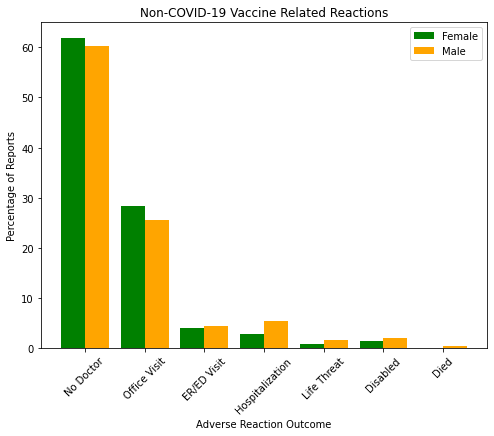

In [38]:
x = notcovid_outcomes_df.index
y1 = 100 * notcovid_outcomes_df["F"] / sum(notcovid_outcomes_df["F"])
y2 = 100 * notcovid_outcomes_df["M"] / sum(notcovid_outcomes_df["M"])

plt.figure(figsize = (8, 6))

plt.bar(x, y1, width = -0.4, align = "edge", color = "green")
plt.bar(x, y2, width = 0.4, align = "edge", color = "orange")
plt.title("Non-COVID-19 Vaccine Related Reactions")
plt.xlabel("Adverse Reaction Outcome")
plt.xticks(rotation = 45)
plt.ylabel("Percentage of Reports")
plt.legend(["Female", "Male"])

plt.savefig("Images/notcovid_genderbar.png")
plt.show()